# N9_4B — Preference-Driven Policy Improvement as KL-Regularized Control

This notebook implements **Mini-Project B** from Section 9.4:

- A **contextual bandit** with contexts \(s\in\mathcal S\) and actions \(a\in\mathcal A\).
- The agent does **not** observe numeric rewards. Instead it receives **pairwise preferences**
  \((a \succ a')\) in context \(s\).
- We:
  1. Fit a **preference model** \(\widehat r_\phi(s,a)\) from comparisons (Bradley–Terry / logistic).
  2. Starting from a reference policy \(\pi_0\), perform **KL-regularized policy improvement**
     via a multiplicative-weights update:
     \[
       \pi_{k+1}(\cdot\mid s)\;\propto\;\pi_k(\cdot\mid s)\exp\big(\eta\,\widehat r_\phi(s,\cdot)\big).
     \]
  3. Plot: (i) regret (and success) vs iteration, (ii) stepwise KL, (iii) calibration of the preference model.

Figures are saved as **PNG** under `figs/`.


In [1]:
# Imports and reproducibility
import os
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

print("OK — figs/ directory:", os.path.abspath(FIG_DIR))

OK — figs/ directory: /Users/chertkov/Dropbox/Apps/Overleaf/MathGenAIBook/notebooks-new/Synthesis/figs


## 1) Environment: contextual bandit with latent (true) reward

We define a small contextual bandit:
- \(|\mathcal S| = S\) contexts, \(|\mathcal A| = A\) actions
- true (latent) reward table \(r_\star(s,a)\) (unknown to the learner)
- preferences are generated as noisy comparisons between two actions in a context:
\[
\Pr[a \succ a' \mid s] = \sigma\big(\beta (r_\star(s,a) - r_\star(s,a'))\big),
\]
where \(\sigma\) is the logistic function and \(\beta\) controls preference noise.


In [2]:
# Problem size and preference noise
S = 8      # number of contexts
A = 6      # number of actions per context
beta = 2.0 # preference sharpness (higher = less noisy)

# True reward table r_star(s,a) (latent ground truth)
r_star = rng.normal(size=(S, A))
# add mild structure
r_star += 0.3 * rng.normal(size=(S, 1)) + 0.3 * rng.normal(size=(1, A))

# Optimal action and value for each context
a_star = np.argmax(r_star, axis=1)
v_star = r_star[np.arange(S), a_star]

print("S, A =", S, A)
print("Mean optimal reward:", float(v_star.mean()))

S, A = 8 6
Mean optimal reward: 0.980733814773789


## 2) Data: pairwise preference comparisons

In [3]:
# Generate preference dataset
N_pairs = 8000  # number of pairwise comparisons
contexts = rng.integers(0, S, size=N_pairs)
a1 = rng.integers(0, A, size=N_pairs)
a2 = rng.integers(0, A, size=N_pairs)
mask = a1 == a2
a2[mask] = (a2[mask] + 1) % A

p = sigmoid(beta * (r_star[contexts, a1] - r_star[contexts, a2]))
y = (rng.random(size=N_pairs) < p).astype(np.float64)

print("Dataset size:", N_pairs)
print("Preference rate (mean y):", float(y.mean()))

Dataset size: 8000
Preference rate (mean y): 0.4905


## 3) Preference model: Bradley–Terry / logistic

We fit parameters \(\theta(s,a)\) with:
\[
\Pr[a \succ a' \mid s] = \sigma(\theta(s,a) - \theta(s,a')).
\]


step  100 | nll_tr=0.4437 | nll_va=0.4378
step  200 | nll_tr=0.4261 | nll_va=0.4185
step  300 | nll_tr=0.4220 | nll_va=0.4132
step  400 | nll_tr=0.4206 | nll_va=0.4110
step  500 | nll_tr=0.4200 | nll_va=0.4100
step  600 | nll_tr=0.4197 | nll_va=0.4095
step  700 | nll_tr=0.4195 | nll_va=0.4092
step  800 | nll_tr=0.4194 | nll_va=0.4090


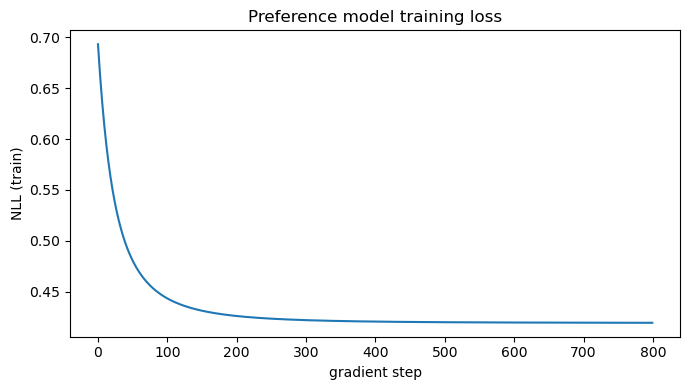

Saved: figs/preference_model_training_loss.png


In [4]:
theta = np.zeros((S, A), dtype=np.float64)

def nll_and_grad(theta, s, a, ap, y, l2=1e-3):
    d = theta[s, a] - theta[s, ap]
    p = sigmoid(d)
    eps = 1e-12
    nll = -np.mean(y*np.log(p+eps) + (1-y)*np.log(1-p+eps))
    g = (p - y) / len(y)
    grad = np.zeros_like(theta)
    np.add.at(grad, (s, a), g)
    np.add.at(grad, (s, ap), -g)
    nll += 0.5*l2*np.mean(theta**2)
    grad += (l2/theta.size)*theta
    return nll, grad

# Train/val split
perm = rng.permutation(N_pairs)
split = int(0.8*N_pairs)
tr, va = perm[:split], perm[split:]

s_tr, a1_tr, a2_tr, y_tr = contexts[tr], a1[tr], a2[tr], y[tr]
s_va, a1_va, a2_va, y_va = contexts[va], a1[va], a2[va], y[va]

lr = 2.0
steps = 800
l2 = 1e-3
loss_hist = []

for t in range(steps):
    nll, grad = nll_and_grad(theta, s_tr, a1_tr, a2_tr, y_tr, l2=l2)
    theta -= lr * grad
    loss_hist.append(nll)
    if (t+1) % 100 == 0:
        nll_va, _ = nll_and_grad(theta, s_va, a1_va, a2_va, y_va, l2=l2)
        print(f"step {t+1:4d} | nll_tr={nll:.4f} | nll_va={nll_va:.4f}")

plt.figure(figsize=(7,4))
plt.plot(loss_hist)
plt.xlabel("gradient step")
plt.ylabel("NLL (train)")
plt.title("Preference model training loss")
out = os.path.join(FIG_DIR, "preference_model_training_loss.png")
plt.tight_layout()
plt.savefig(out, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out)

## 4) KL-regularized policy improvement

Update:
\[
\pi_{k+1}(a\mid s) \propto \pi_k(a\mid s)\exp(\eta\,\theta(s,a)).
\]
We track regret, success probability, and stepwise KL.


In [5]:
def normalize_rows(x):
    x = np.maximum(x, 1e-15)
    return x / x.sum(axis=1, keepdims=True)

def kl_rowwise(p, q):
    eps = 1e-15
    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)
    return np.sum(p * (np.log(p) - np.log(q)), axis=1)

def policy_update(pi, score, eta):
    w = pi * np.exp(eta * score)
    return normalize_rows(w)

pi = np.ones((S, A), dtype=np.float64) / A

K = 60
eta = 0.8

reward_hist, regret_hist, success_hist, kl_hist = [], [], [], []

for k in range(K):
    exp_reward = np.mean(np.sum(pi * r_star, axis=1))
    regret = float(np.mean(v_star) - exp_reward)
    success = np.mean(pi[np.arange(S), a_star])
    reward_hist.append(exp_reward)
    regret_hist.append(regret)
    success_hist.append(success)

    pi_next = policy_update(pi, theta, eta)
    kl = np.mean(kl_rowwise(pi_next, pi))
    kl_hist.append(kl)
    pi = pi_next

reward_hist = np.array(reward_hist)
regret_hist = np.array(regret_hist)
success_hist = np.array(success_hist)
kl_hist = np.array(kl_hist)

print("Final success prob:", float(success_hist[-1]))
print("Final regret:", float(regret_hist[-1]))

Final success prob: 0.8784467409615591
Final regret: 0.015664654193686234


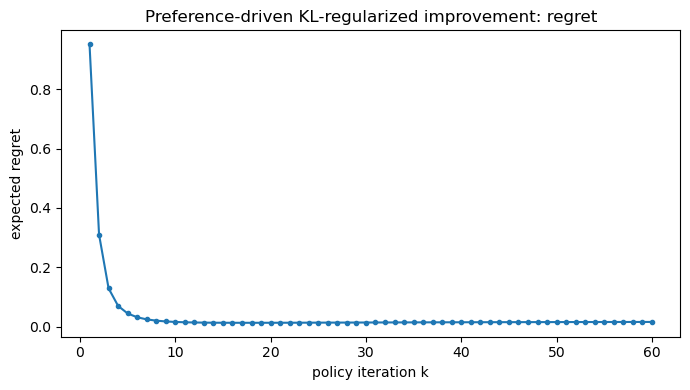

Saved: figs/preference_KL_regret.png


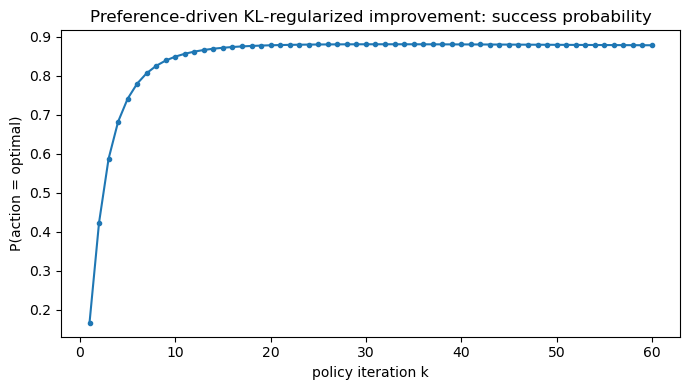

Saved: figs/preference_KL_success.png


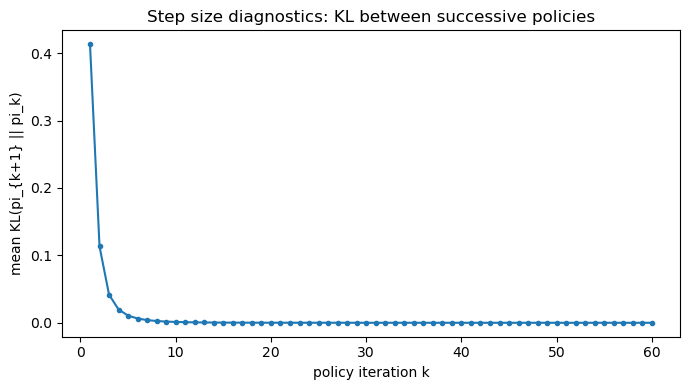

Saved: figs/preference_KL_stepsize.png


In [6]:
it = np.arange(1, K+1)

plt.figure(figsize=(7,4))
plt.plot(it, regret_hist, marker='o', markersize=3)
plt.xlabel("policy iteration k")
plt.ylabel("expected regret")
plt.title("Preference-driven KL-regularized improvement: regret")
out1 = os.path.join(FIG_DIR, "preference_KL_regret.png")
plt.tight_layout()
plt.savefig(out1, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out1)

plt.figure(figsize=(7,4))
plt.plot(it, success_hist, marker='o', markersize=3)
plt.xlabel("policy iteration k")
plt.ylabel("P(action = optimal)")
plt.title("Preference-driven KL-regularized improvement: success probability")
out2 = os.path.join(FIG_DIR, "preference_KL_success.png")
plt.tight_layout()
plt.savefig(out2, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out2)

plt.figure(figsize=(7,4))
plt.plot(it, kl_hist, marker='o', markersize=3)
plt.xlabel("policy iteration k")
plt.ylabel("mean KL(pi_{k+1} || pi_k)")
plt.title("Step size diagnostics: KL between successive policies")
out3 = os.path.join(FIG_DIR, "preference_KL_stepsize.png")
plt.tight_layout()
plt.savefig(out3, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out3)

## 5) Preference-model calibration

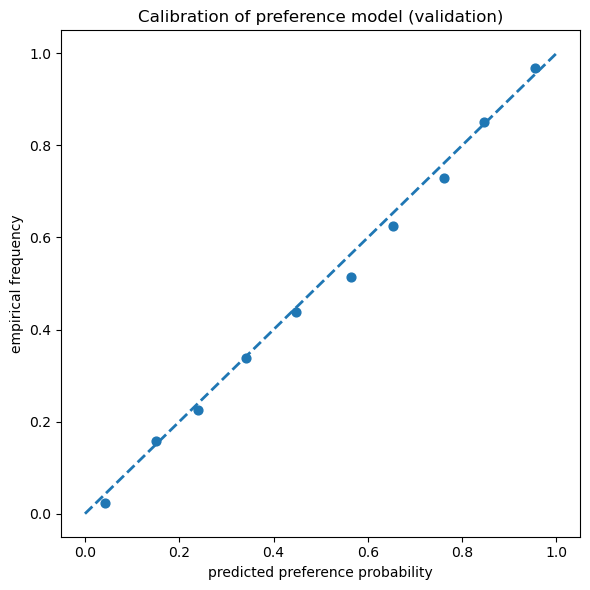

Saved: figs/preference_model_calibration.png
Brier score (lower is better): 0.13227762648943156


In [7]:
def predict_pref_prob(theta, s, a, ap):
    d = theta[s, a] - theta[s, ap]
    return sigmoid(d)

p_hat = predict_pref_prob(theta, s_va, a1_va, a2_va)

bins = np.linspace(0.0, 1.0, 11)
bin_ids = np.digitize(p_hat, bins) - 1
bin_centers = 0.5*(bins[:-1] + bins[1:])

emp, pred, counts = [], [], []
for b in range(len(bin_centers)):
    m = bin_ids == b
    if np.any(m):
        emp.append(np.mean(y_va[m]))
        pred.append(np.mean(p_hat[m]))
        counts.append(np.sum(m))
    else:
        emp.append(np.nan)
        pred.append(np.nan)
        counts.append(0)

emp = np.array(emp, dtype=float)
pred = np.array(pred, dtype=float)

plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1], linestyle='--', linewidth=2)
plt.scatter(pred[~np.isnan(emp)], emp[~np.isnan(emp)], s=40)
plt.xlabel("predicted preference probability")
plt.ylabel("empirical frequency")
plt.title("Calibration of preference model (validation)")
out4 = os.path.join(FIG_DIR, "preference_model_calibration.png")
plt.tight_layout()
plt.savefig(out4, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out4)

brier = np.mean((p_hat - y_va)**2)
print("Brier score (lower is better):", float(brier))

## 6) Consolidated 1x3 summary figure (for the book)

Saves to `figs/preference_KL_results.png`.


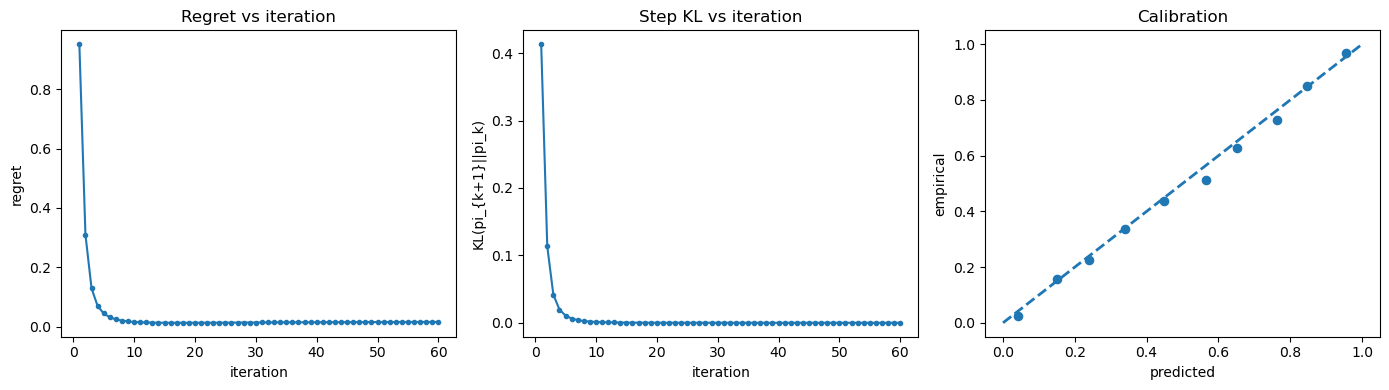

Saved: figs/preference_KL_results.png


In [8]:
fig = plt.figure(figsize=(14,4))

ax1 = fig.add_subplot(1,3,1)
ax1.plot(it, regret_hist, marker='o', markersize=3)
ax1.set_xlabel("iteration")
ax1.set_ylabel("regret")
ax1.set_title("Regret vs iteration")

ax2 = fig.add_subplot(1,3,2)
ax2.plot(it, kl_hist, marker='o', markersize=3)
ax2.set_xlabel("iteration")
ax2.set_ylabel("KL(pi_{k+1}||pi_k)")
ax2.set_title("Step KL vs iteration")

ax3 = fig.add_subplot(1,3,3)
ax3.plot([0,1],[0,1], linestyle='--', linewidth=2)
ax3.scatter(pred[~np.isnan(emp)], emp[~np.isnan(emp)], s=35)
ax3.set_xlabel("predicted")
ax3.set_ylabel("empirical")
ax3.set_title("Calibration")

plt.tight_layout()
out5 = os.path.join(FIG_DIR, "preference_KL_results.png")
plt.savefig(out5, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out5)

## 7) Suggested extensions (for open-ended exercises)

- Vary preference noise `beta` and dataset size `N_pairs`.
- Vary update strength `eta` and monitor stepwise KL.
- Replace tabular scores `theta(s,a)` with a feature model `⟨w, f(s,a)⟩`.
- Non-uniform context sampling.
